<a href="https://colab.research.google.com/github/FernandoMdAraujo/PCS5024---Aprendizado-Estat-stico/blob/main/RAVDESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bibliotecas

Import Libraries

In [ ]:
pip install optuna

In [2]:
from sklearn.utils.fixes import sklearn
import pandas as pd
import numpy as np
import os
import random
import sys
import glob 
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import librosa, librosa.display

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import IPython.display as ipd
from IPython.display import Audio
import time

import warnings
warnings.filterwarnings('ignore')

## Acessando Drive

In [3]:
#from google.colab import auth
#auth.authenticate_user()

#from googleapiclient.discovery import build
#drive_service = build('drive', 'v3')

##Baixar Dataset .zip

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip

##Descompactando Arquivo zip

In [ ]:
!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'

##Excluindo arquivo .zip para não sobrecarregar o servidor

In [5]:
!rm Audio_Speech_Actors_01-24.zip

##Testando Audio

In [6]:
x, sr = librosa.load('/content/Audio_Speech_Actors/Actor_01/03-01-01-01-01-01-01.wav', sr = 16000, mono = True)
ipd.Audio(x, rate=sr)

In [7]:
#RavdessData = "C:\\Users\\arauj\\OneDrive\\Documentos\\USP\\Mestrado\\PSI5123 - Aprendizagem de Máquina de Sinais de Áudio e Voz\\ravdess\\audio_speech_actors_01-24" 
RavdessData = '/content/Audio_Speech_Actors/'

In [8]:
ravdessDirectoryList = os.listdir(RavdessData)
fileEmotion = []
filePath =[]
for dir in ravdessDirectoryList:
  actor = os.listdir(RavdessData + dir)
  for file in actor:
    part = file.split('.')[0]
    part = part.split('-')
    fileEmotion.append(int(part[2]))
    filePath.append(RavdessData + dir + '/' + file)
emotion_df = pd.DataFrame(fileEmotion, columns=['Emotions'])
path_df = pd.DataFrame(filePath, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

In [ ]:
Ravdess_df.Emotions.replace({
  1:'neutra', #neutral
  2:'calma', #calm
  3:'feliz', #happy
  4:'triste', #sad
  5:'nervoso', # angry
  6:'raiva', #fear
  7:'nojo', #disgust
  8:'surpreso' #surprise
}, inplace=True)
Ravdess_df.head()

In [ ]:
dataPath = pd.concat([Ravdess_df], axis = 0)
dataPath.to_csv("data.path.csv", index=False)
dataPath.head()

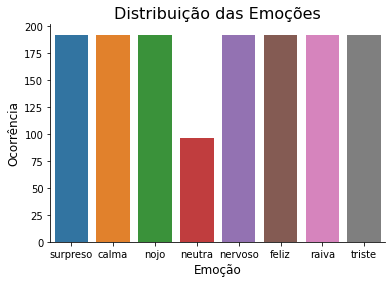

In [11]:
plt.title('Distribuição das Emoções', size=16)
sns.countplot(dataPath.Emotions)
plt.ylabel('Ocorrência', size=12)
plt.xlabel('Emoção', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
def formadeonda(data, sr, e):
  plt.figure(figsize=(10,3))
  plt.title('Forma de onda para audio com a emoção: {}'.format(e), size=15)
  librosa.display.waveplot(data,sr=sr)
  plt.show()

In [13]:
def espectrograma(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,3))
  plt.title('Espectrograma para o audio com a emoção: {}'.format(e), size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis = 'time', y_axis = 'hz')
  plt.colorbar()

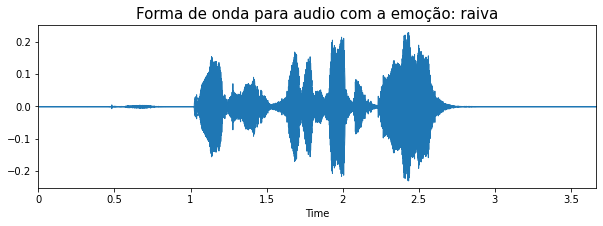

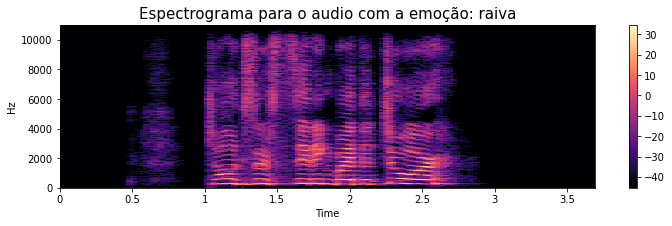

In [14]:
emotion ='raiva'
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data,samplingRate =librosa.load(path)
formadeonda(data, samplingRate, emotion)
espectrograma(data, samplingRate, emotion)
Audio(path)

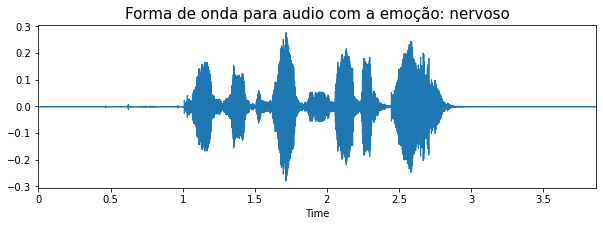

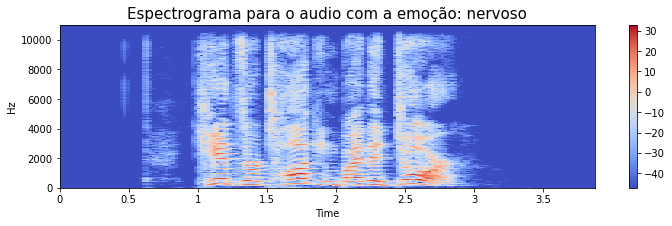

In [15]:
emotion ='nervoso' #5 angry
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data,samplingRate =librosa.load(path)
formadeonda(data, samplingRate, emotion)
espectrograma(data, samplingRate, emotion)
Audio(path)

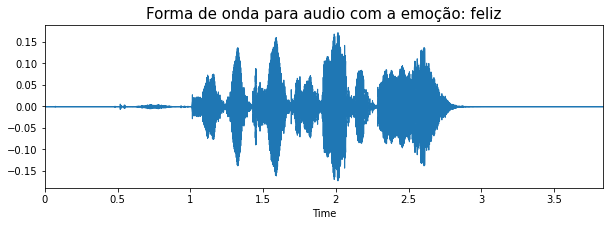

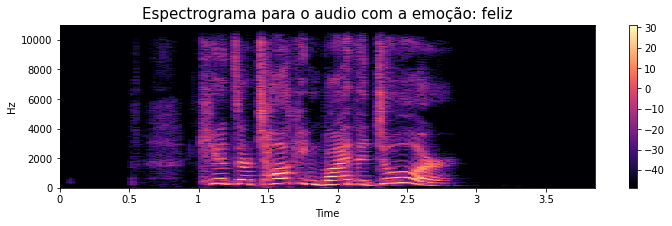

In [16]:
emotion ='feliz' #3 happy
path = np.array(dataPath.Path[dataPath.Emotions==emotion])[1]
data,samplingRate =librosa.load(path)
formadeonda(data, samplingRate, emotion)
espectrograma(data, samplingRate, emotion)
Audio(path)

In [17]:
def noise(data):
  noiseAmp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noiseAmp*np.random.normal(size=data.shape[0])
  return data

def stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate)

def shift(data):
  shiftRange = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shiftRange)

def pitch(data, samplingRate, pitchFactor=0.7):
  return librosa.effects.pitch_shift(data, samplingRate, pitchFactor)

In [18]:
path = np.array(dataPath.Path)[1]
data, sampleRate =librosa.load(path)

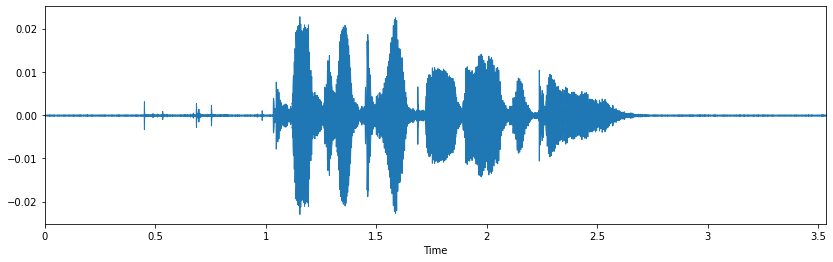

In [19]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

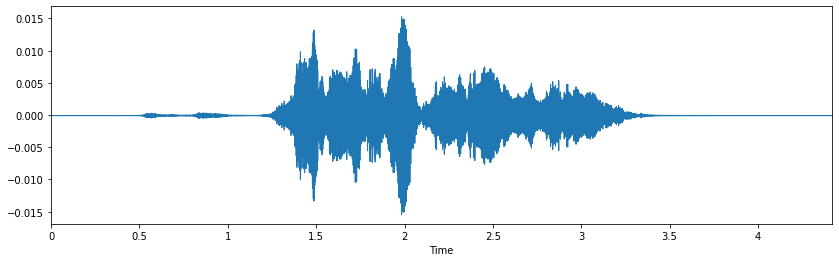

In [20]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

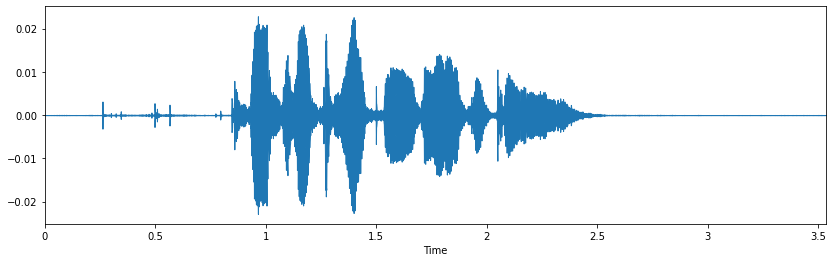

In [21]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

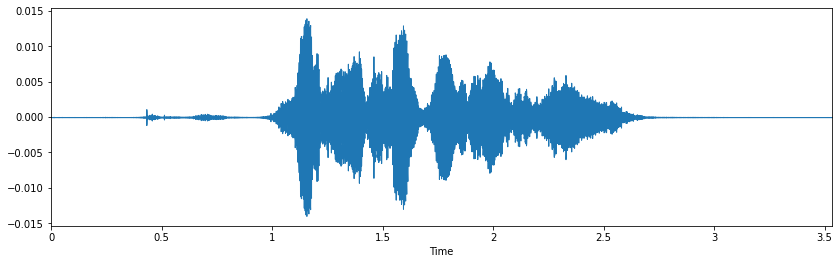

In [22]:
x = pitch(data, sampleRate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sampleRate)
Audio(x, rate=sampleRate)

In [23]:
def extractFeature(fileName, mfcc, chroma, mel):
  with soundfile.SoundFile(fileName) as soundFile:
    X = soundFile.read(dtype="float32")
    sampleRate = soundFile.samplerate
    if chroma:
      stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sampleRate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampleRate).T, axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(X, sr=sampleRate).T, axis=0)
      result=np.hstack((result, mel))
  result

In [24]:
def extract_feature(file_name):
    """Function Extracts Features from WAV file"""
    X, sample_rate = librosa.load(file_name)
    stft=np.abs(librosa.stft(X))
    result=np.array([])
    mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    return result

In [25]:
emotions={
  '01':'neutra',
  '02':'calma',
  '03':'feliz',
  '04':'triste',
  '05':'nervoso',
  '06':'raiva',
  '07':'nojo',
  '08':'surpreso'
}
observedEmotions=['neutra', 'calma', 'feliz', 'triste', 'nervoso', 'raiva', 'nojo' ,'surpreso']

In [26]:
def loadData(test_size=0.2):
  x,y=[],[]
  for file in glob.glob('/content/Audio_Speech_Actors/Actor_*//*.wav'):
    #RavdessData = '/content/Audio_Speech_Actors/'
    fileName = os.path.basename(file)
    emotion1 = emotions[fileName.split("-")[2]]
    if emotion1 not in observedEmotions:
      continue
    #feature=extractFeature(file, mfcc=True, chroma=True, mel=True)
    feature=extract_feature(file)
    x.append(feature)
    y.append(emotion1)
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [27]:
xTrain, xTest, yTrain, yTest = loadData(test_size=0.23)

In [28]:
print((xTrain.shape[0], xTest.shape[0]))

(1108, 332)


In [29]:
print(f' Características extraídas: {xTrain.shape[1]}')

 Características extraídas: 180


##**MLP - Função Pronta**

In [30]:
model =MLPClassifier(alpha=0.01, batch_size=15, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [40]:
model.fit(xTrain, yTrain)

MLPClassifier(alpha=0.01, batch_size=15, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [41]:
expected_of_y = yTest
yPred = model.predict(xTest)

In [42]:
print(metrics.confusion_matrix(expected_of_y, yPred))

[[31  2  1  3  1  3  0  0]
 [ 2 23  2  2  4  2  3  3]
 [ 0  3 33  0  3  7  3  0]
 [ 6  1  1 11  0  1  3  3]
 [ 6  2  1  2 21  4  3  1]
 [ 2  3  0  0  0 33  2  1]
 [ 0  3  0  6  6  3 24  0]
 [ 6  5  0  2  1 13  1 24]]


In [43]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

       calma       0.58      0.76      0.66        41
       feliz       0.55      0.56      0.55        41
     nervoso       0.87      0.67      0.76        49
      neutra       0.42      0.42      0.42        26
        nojo       0.58      0.53      0.55        40
       raiva       0.50      0.80      0.62        41
    surpreso       0.62      0.57      0.59        42
      triste       0.75      0.46      0.57        52

    accuracy                           0.60       332
   macro avg       0.61      0.60      0.59       332
weighted avg       0.63      0.60      0.60       332



In [44]:
acuracia = accuracy_score(y_true=yTest, y_pred=yPred)

print("Acurácia: {:.2f}%".format(acuracia*100))

Acurácia: 60.24%


In [45]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, model='clf', save=True):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, ax=ax, fmt="d", cmap=plt.cm.Oranges)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Rótulos Verdadeiros')
    plt.xlabel('Rótulos Preditos')
    plt.tight_layout()
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    if save == True:
        plt.savefig('confusion_matrix.jpg')
    plt.show()

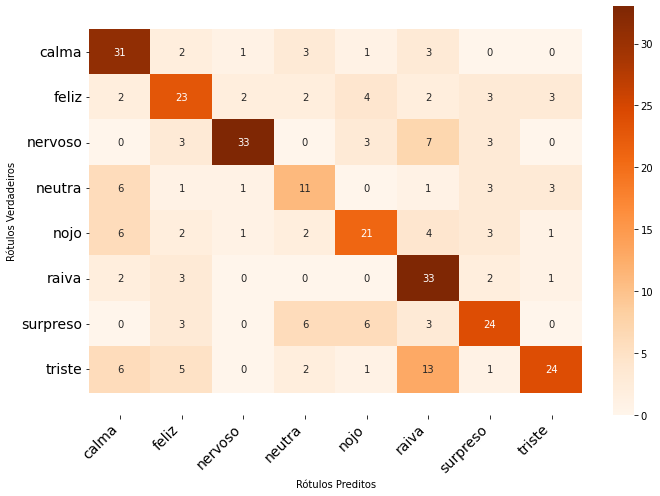

In [47]:
print_confusion_matrix(confusion_matrix(yTest, yPred), unique_labels(yTest, yPred), model=MLPClassifier)

## Otmização do MLP

In [ ]:
#mlp = MLPClassifier(max_iter=500)
# Definindo valores dos hyperparametros para serem testados
#parameter_space = {
#    'hidden_layer_sizes': [(180, 90, 45, 8), (50,50,50), (180, 90 ,8)],
#    'activation': ['tanh', 'relu'],
#    'solver': ['sgd', 'adam'],
#    'alpha': [0.0001, 0.05],
#    'learning_rate': ['constant','adaptive'],
#}
# Chamando a funcao para otimizar os hyperparametros do MLP (n_jobs corresponde ao numero de CPUs disponiveis)
#clf_MLP = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
# Executando no Conjunto de Treinamento
#best_model = clf_MLP.fit(xTrain, yTrain)
# Imprimindo melhores valores 
#print(f'Melhores parametros: {best_model.best_params_}')

##MLP - Pytorch

In [54]:
yTrain

['nojo',
 'feliz',
 'nervoso',
 'raiva',
 'raiva',
 'calma',
 'nojo',
 'raiva',
 'raiva',
 'neutra',
 'surpreso',
 'raiva',
 'feliz',
 'feliz',
 'triste',
 'neutra',
 'calma',
 'nojo',
 'neutra',
 'raiva',
 'nojo',
 'raiva',
 'surpreso',
 'surpreso',
 'calma',
 'raiva',
 'raiva',
 'neutra',
 'surpreso',
 'calma',
 'raiva',
 'triste',
 'feliz',
 'calma',
 'nervoso',
 'triste',
 'calma',
 'nojo',
 'nojo',
 'raiva',
 'raiva',
 'feliz',
 'triste',
 'nervoso',
 'feliz',
 'raiva',
 'nervoso',
 'nojo',
 'feliz',
 'nervoso',
 'feliz',
 'triste',
 'raiva',
 'raiva',
 'nervoso',
 'nojo',
 'surpreso',
 'triste',
 'nervoso',
 'triste',
 'raiva',
 'feliz',
 'calma',
 'triste',
 'triste',
 'calma',
 'feliz',
 'feliz',
 'feliz',
 'feliz',
 'nojo',
 'surpreso',
 'nervoso',
 'triste',
 'surpreso',
 'calma',
 'nojo',
 'nervoso',
 'surpreso',
 'feliz',
 'nervoso',
 'nojo',
 'nojo',
 'surpreso',
 'nojo',
 'surpreso',
 'calma',
 'triste',
 'nervoso',
 'nervoso',
 'surpreso',
 'feliz',
 'nojo',
 'triste',
 

In [55]:
yTrain_num = np.zeros(len(yTrain))

In [56]:
yTest_num = np.zeros(len(yTest))

In [57]:
for i in range(len(yTest)):
  if yTest[i] == 'neutra': yTest_num[i] = 1
  elif yTest[i] == 'calma': yTest_num[i] = 2 
  elif yTest[i] == 'feliz': yTest_num[i] = 3 
  elif yTest[i] == 'triste': yTest_num[i] = 4 
  elif yTest[i] == 'nervoso': yTest_num[i] = 5 
  elif yTest[i] == 'raiva': yTest_num[i] = 6 
  elif yTest[i] == 'nojo': yTest_num[i] = 7 
  else: yTest_num[i] = 8

In [58]:
for i in range(len(yTrain)):
  if yTrain[i] == 'neutra': yTrain_num[i] = 1
  elif yTrain[i] == 'calma': yTrain_num[i] = 2 
  elif yTrain[i] == 'feliz': yTrain_num[i] = 3 
  elif yTrain[i] == 'triste': yTrain_num[i] = 4 
  elif yTrain[i] == 'nervoso': yTrain_num[i] = 5 
  elif yTrain[i] == 'raiva': yTrain_num[i] = 6 
  elif yTrain[i] == 'nojo': yTrain_num[i] = 7 
  else: yTrain_num[i] = 8

In [59]:
print(yTest_num)

[6. 5. 6. 8. 6. 5. 8. 1. 5. 8. 1. 2. 4. 3. 2. 4. 8. 4. 2. 4. 8. 7. 6. 8.
 7. 3. 7. 7. 5. 3. 2. 6. 3. 1. 8. 2. 6. 5. 8. 8. 8. 7. 7. 6. 3. 1. 6. 4.
 6. 3. 4. 5. 7. 7. 3. 5. 2. 2. 4. 8. 6. 4. 1. 4. 7. 2. 4. 2. 2. 7. 2. 7.
 4. 5. 2. 7. 1. 2. 8. 3. 1. 2. 1. 5. 3. 2. 5. 5. 6. 4. 7. 5. 4. 5. 6. 3.
 6. 2. 5. 8. 7. 5. 3. 4. 7. 8. 8. 1. 8. 3. 2. 1. 6. 6. 2. 5. 4. 3. 5. 5.
 6. 8. 5. 8. 2. 4. 1. 4. 1. 6. 8. 5. 3. 2. 3. 5. 6. 4. 6. 4. 3. 8. 4. 2.
 3. 6. 2. 4. 4. 1. 4. 5. 4. 2. 3. 6. 8. 5. 4. 1. 6. 4. 4. 3. 4. 5. 7. 7.
 4. 7. 3. 5. 8. 1. 8. 3. 2. 7. 7. 1. 6. 6. 3. 5. 6. 7. 4. 4. 5. 5. 8. 3.
 4. 3. 7. 5. 2. 6. 4. 5. 4. 4. 2. 4. 8. 5. 5. 2. 8. 5. 3. 5. 2. 4. 4. 5.
 8. 1. 1. 2. 1. 3. 2. 2. 3. 3. 5. 7. 2. 1. 3. 5. 8. 7. 5. 8. 7. 4. 4. 8.
 3. 1. 8. 7. 2. 6. 2. 4. 7. 4. 7. 8. 6. 7. 5. 3. 6. 7. 2. 4. 1. 6. 3. 4.
 6. 5. 5. 3. 1. 4. 3. 2. 7. 3. 5. 8. 8. 4. 1. 7. 6. 5. 4. 8. 2. 5. 8. 6.
 7. 5. 6. 3. 7. 5. 3. 7. 4. 1. 8. 3. 5. 8. 8. 3. 6. 8. 3. 5. 6. 2. 7. 7.
 6. 6. 4. 7. 8. 7. 5. 1. 6. 2. 6. 7. 8. 6. 4. 4. 3.

In [60]:
float_list = [np.float32(i) for i in yTrain_num]

In [61]:
entrada = torch.from_numpy(xTrain.astype(np.float32))
saida = torch.FloatTensor(yTrain_num)

In [62]:
entrada_test = torch.from_numpy(xTest.astype(np.float32))
saida_test = torch.FloatTensor(yTest_num)

In [63]:
saida

tensor([7., 3., 5.,  ..., 6., 5., 7.])

In [64]:
saida.size()

torch.Size([1108])

In [65]:
yTest

['raiva',
 'nervoso',
 'raiva',
 'surpreso',
 'raiva',
 'nervoso',
 'surpreso',
 'neutra',
 'nervoso',
 'surpreso',
 'neutra',
 'calma',
 'triste',
 'feliz',
 'calma',
 'triste',
 'surpreso',
 'triste',
 'calma',
 'triste',
 'surpreso',
 'nojo',
 'raiva',
 'surpreso',
 'nojo',
 'feliz',
 'nojo',
 'nojo',
 'nervoso',
 'feliz',
 'calma',
 'raiva',
 'feliz',
 'neutra',
 'surpreso',
 'calma',
 'raiva',
 'nervoso',
 'surpreso',
 'surpreso',
 'surpreso',
 'nojo',
 'nojo',
 'raiva',
 'feliz',
 'neutra',
 'raiva',
 'triste',
 'raiva',
 'feliz',
 'triste',
 'nervoso',
 'nojo',
 'nojo',
 'feliz',
 'nervoso',
 'calma',
 'calma',
 'triste',
 'surpreso',
 'raiva',
 'triste',
 'neutra',
 'triste',
 'nojo',
 'calma',
 'triste',
 'calma',
 'calma',
 'nojo',
 'calma',
 'nojo',
 'triste',
 'nervoso',
 'calma',
 'nojo',
 'neutra',
 'calma',
 'surpreso',
 'feliz',
 'neutra',
 'calma',
 'neutra',
 'nervoso',
 'feliz',
 'calma',
 'nervoso',
 'nervoso',
 'raiva',
 'triste',
 'nojo',
 'nervoso',
 'triste',
 '

In [66]:
tensor_saida = torch.zeros(len(saida),8)
tensor_saida

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [67]:
tensor_saida_test = torch.zeros(len(saida_test),8)
tensor_saida_test

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
#tensor_saida[1,:] = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
#tensor_saida_test[1,:] = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
# Revisar esse for para montar o tensor, devidamente

In [71]:
for i in range(len(yTrain)):
  if yTrain[i] == 'neutra': tensor_saida[i,:] = torch.tensor([1., 0., 0., 0., 0., 0., 0., 0.]) #tensor_saida[[i,yTrain_num[i]]] = 1
  elif yTrain[i] == 'calma': tensor_saida[i,:] = torch.tensor([0., 1., 0., 0., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 2 #tensor_saida[i] == 'calma': tensor_saida[i] = 2 
  elif yTrain[i] == 'feliz': tensor_saida[i,:] = torch.tensor([0., 0., 1., 0., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 3 #tensor_saida[i] == 'feliz': tensor_saida[i] = 3 
  elif yTrain[i] == 'triste': tensor_saida[i,:] = torch.tensor([0., 0., 0., 1., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 4 #tensor_saida[i] == 'triste': tensor_saida[i] = 4 
  elif yTrain[i] == 'nervoso': tensor_saida[i,:] = torch.tensor([0., 0., 0., 0., 1., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 5 #tensor_saida[i] == 'nervoso': tensor_saida[i] = 5 
  elif yTrain[i] == 'raiva': tensor_saida[i,:] = torch.tensor([0., 0., 0., 0., 0., 1., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 6 #tensor_saida[i] == 'raiva': tensor_saida[i] = 6 
  elif yTrain[i] == 'nojo': tensor_saida[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 1., 0.])#tensor_saida[[i,yTrain_num[i]]] = 7 #tensor_saida[i] == 'nojo': tensor_saida[i] = 7 
  else: tensor_saida[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 0., 1.])#tensor_saida[[i,yTrain_num[i]]] = 8 #tensor_saida[i] = 8

In [72]:
for i in range(len(yTest)):
  if yTest[i] == 'neutra': tensor_saida_test[i,:] = torch.tensor([1., 0., 0., 0., 0., 0., 0., 0.]) #tensor_saida[[i,yTrain_num[i]]] = 1
  elif yTest[i] == 'calma': tensor_saida_test[i,:] = torch.tensor([0., 1., 0., 0., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 2 #tensor_saida[i] == 'calma': tensor_saida[i] = 2 
  elif yTest[i] == 'feliz': tensor_saida_test[i,:] = torch.tensor([0., 0., 1., 0., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 3 #tensor_saida[i] == 'feliz': tensor_saida[i] = 3 
  elif yTest[i] == 'triste': tensor_saida_test[i,:] = torch.tensor([0., 0., 0., 1., 0., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 4 #tensor_saida[i] == 'triste': tensor_saida[i] = 4 
  elif yTest[i] == 'nervoso': tensor_saida_test[i,:] = torch.tensor([0., 0., 0., 0., 1., 0., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 5 #tensor_saida[i] == 'nervoso': tensor_saida[i] = 5 
  elif yTest[i] == 'raiva': tensor_saida_test[i,:] = torch.tensor([0., 0., 0., 0., 0., 1., 0., 0.])#tensor_saida[[i,yTrain_num[i]]] = 6 #tensor_saida[i] == 'raiva': tensor_saida[i] = 6 
  elif yTest[i] == 'nojo': tensor_saida_test[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 1., 0.])#tensor_saida[[i,yTrain_num[i]]] = 7 #tensor_saida[i] == 'nojo': tensor_saida[i] = 7 
  else: tensor_saida_test[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 0., 1.])#tensor_saida[[i,yTrain_num[i]]] = 8 #tensor_saida[i] = 8

In [73]:
#tensor_saida = torch.tensor([0,0,0,0,0,0,0,0]) #tensor_saida[[i,yTrain_num[i]]]
tensor_saida_test

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [74]:
print(tensor_saida[567,:])

tensor([0., 0., 0., 0., 1., 0., 0., 0.])


In [75]:
print(yTrain_num[567])

5.0


In [76]:
print(yTrain[567])

nervoso


In [77]:
tensor_saida

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [78]:
tensor_saida_test

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [79]:
INPUT_DIM = xTrain.shape[1]
OUTPUT_DIM = 8 #numero de emoções

In [80]:
class MLP1(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP1, self).__init__()
    self.fc0 = torch.nn.Linear(input_dim,1800)
    self.fc1 = torch.nn.Linear(1800,1024)
    self.ativacao = torch.nn.functional.sigmoid
    self.fc2 = torch.nn.Linear(1024,256)
    self.fc3 = torch.nn.Linear(256,64)
    self.fc4 = torch.nn.Linear(64,8)
  
  def forward(self, entrada):
    y = self.fc0(entrada)
    y = self.ativacao(y)
    #y = F.relu(self.input_fc1(y))
    y = self.fc1(y)
    y = self.ativacao(y)
    y = self.fc2(y)
    y = self.ativacao(y)
    y = self.fc3(y)
    #k = tensor_codificado(y)
    y = self.ativacao(y)
    y = self.fc4(y)
    #y = self.ativacao(y)
    #y = self.fc5(y)
    return y

In [81]:
def tensor_codificado(y):
  #x_tensor = torch.zeros(len(y),8)
  um = torch.tensor(1)
  maximo = torch.zeros(len(y))
  maximo = torch.argmax(y, dim=-1)
  for i in range(len(maximo)):
    maximo[i] = maximo[i] + um
    #if maximo[i] == 0: x_tensor[i,:] = torch.tensor([1., 0., 0., 0., 0., 0., 0., 0.]) 
    #elif maximo[i] == 1: x_tensor[i,:] = torch.tensor([0., 1., 0., 0., 0., 0., 0., 0.]) 
    #elif maximo[i] == 2: x_tensor[i,:] = torch.tensor([0., 0., 1., 0., 0., 0., 0., 0.])
    #elif maximo[i] == 3: x_tensor[i,:] = torch.tensor([0., 0., 0., 1., 0., 0., 0., 0.])
    #elif maximo[i] == 4: x_tensor[i,:] = torch.tensor([0., 0., 0., 0., 1., 0., 0., 0.])
    #elif maximo[i] == 5: x_tensor[i,:] = torch.tensor([0., 0., 0., 0., 0., 1., 0., 0.])
    #elif maximo[i] == 6: x_tensor[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 1., 0.])
    #else: x_tensor[i,:] = torch.tensor([0., 0., 0., 0., 0., 0., 0., 1.])
  return maximo

In [82]:
saida[32]

tensor(3.)

In [83]:
torch.argmax(saida, dim=-1)

tensor(10)

In [84]:
saida.shape

torch.Size([1108])

In [85]:
tensor_saida.shape

torch.Size([1108, 8])

In [86]:
k = tensor_codificado(tensor_saida)
k

tensor([7, 3, 5,  ..., 6, 5, 7])

In [87]:
class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred

In [88]:
net = MLP1(INPUT_DIM, OUTPUT_DIM)
print(net)

MLP1(
  (fc0): Linear(in_features=180, out_features=1800, bias=True)
  (fc1): Linear(in_features=1800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [89]:
net2 = MLP1(INPUT_DIM, OUTPUT_DIM)
print(net2)

MLP1(
  (fc0): Linear(in_features=180, out_features=1800, bias=True)
  (fc1): Linear(in_features=1800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [90]:
def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'O modelo tem {count_parameters(net):,} parâmetros treináveis')

O modelo tem 2,449,392 parâmetros treináveis


In [451]:
#net.state_dict()

In [91]:
learning_rate_pytorch = 0.01

#optimizer = optim.Adam(net.parameters(), lr=learning_rate_pytorch)
optimizer = torch.optim.SGD(net.parameters(),lr=learning_rate_pytorch)
#loss_func = nn.CrossEntropyLoss()
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.BCELoss()

In [92]:
criterion = nn.CrossEntropyLoss()

In [93]:
epochs = 1000
loss_data = np.zeros(epochs)

for epoch in range(epochs):
  prediction = net(entrada)

  m = nn.Sigmoid()
  loss = loss_func(m(prediction), tensor_saida)
  #loss = criterion(prediction, tensor_saida)
  loss_data[epoch] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #acc = accuracy_score(y_true=tensor_saida, y_pred=prediction)
  if epoch %50 == 0:
    print(f'epoch {epoch+1} loss={loss.item():.8f}')

epoch 1 loss=0.22369148
epoch 51 loss=0.19628540
epoch 101 loss=0.17534781
epoch 151 loss=0.15976131
epoch 201 loss=0.14828816
epoch 251 loss=0.13982588
epoch 301 loss=0.13352121
epoch 351 loss=0.12875938
epoch 401 loss=0.12510988
epoch 451 loss=0.12227271
epoch 501 loss=0.12003747
epoch 551 loss=0.11825477
epoch 601 loss=0.11681712
epoch 651 loss=0.11564596
epoch 701 loss=0.11468317
epoch 751 loss=0.11388506
epoch 801 loss=0.11321849
epoch 851 loss=0.11265793
epoch 901 loss=0.11218354
epoch 951 loss=0.11177979


In [90]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [91]:
saida_test.shape[1]

IndexError: ignored

In [92]:
net1 = MLP1(180, OUTPUT_DIM)
print(net1)

MLP1(
  (fc0): Linear(in_features=180, out_features=360, bias=True)
  (fc1): Linear(in_features=360, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=8, bias=True)
)


In [ ]:
epochs = 10
loss_valid = np.zeros(epochs)
for epoch in range(epochs):
  saida_real = net1(entrada_test)
  loss = loss_func(saida_real, tensor_saida_test)
  loss_data[epoch] = loss.item()
  #acc = accuracy_score(y_true=saida_real, y_pred=tensor_saida_test)
  print(f'epoch {epoch+1} loss={loss.item():.8f}, acuracia={2}')

In [96]:
saida_real.shape

torch.Size([332, 8])

In [351]:
tensor_saida_test.shape

torch.Size([332, 8])

In [98]:
tensor_saida_test

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [135]:
saida_real[50]

tensor([ 0.0557, -0.0984,  0.0480, -0.1611, -0.7475,  0.6230,  0.1171, -0.1039],
       grad_fn=<SelectBackward0>)

In [352]:
tensor_saida[50]

tensor([0., 0., 1., 0., 0., 0., 0., 0.])

In [353]:
prediction

tensor([[2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08],
        [2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08],
        [2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08],
        ...,
        [2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08],
        [2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08],
        [2.0036e-08, 7.4513e-09, 8.0468e-09,  ..., 1.2169e-08, 1.0353e-08,
         1.1073e-08]], grad_fn=<SigmoidBackward0>)

In [ ]:
yTrain_num